---
title: Human-Neanderthal admixture
date: last-modified
author: Kasper Munch

---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from IPython.display import Markdown

%matplotlib inline
%config InlineBackend.figure_format='svg'

from genominterv.decorators import bootstrap
from genominterv.stats import proximity_stat, jaccard_stat

from scipy.stats import fisher_exact

import geneinfo.plot as gplt
import geneinfo.information as gi
import geneinfo.utils as utils
# utils.clear_cache()
# utils.disable_cache = True
from geneinfo.utils import GeneListCollection
from geneinfo.utils import GeneList as glist

sheet = GeneListCollection(google_sheet='1JSjSLuto3jqdEnnG7JqzeC_1pUZw76n7XueVAYrUOpk')

In [3]:
df = pd.read_csv('../data/Human_cell_xy_mast_output_flt.tsv', sep='\t')
# df = pd.read_csv('../data/Human_xy_mast_output_flt.tsv', sep='\t')
df = df.loc[~df.signif.isnull()]
for x in df.signif:
    print(x)

AFF2
CFAP47
DIAPH2
DYNLT3
EDA
EIF1AX
GLOD5
HUWE1
IQSEC2
LAS1L
OCRL
OFD1
PDK3
PHF8
PPEF1
PPP1R2C
PRICKLE3
RBM41
RPGR
RTL4
SYP
SYTL5
UPF3B
ZCCHC13
mc_ampl_PRDX4
mc_ampl_SPANXN5
mc_ampl_TSPAN7


Also include these in the admixture project and import to this:

```txt
argweaver-d/introgressionHub/files/M1A/afr1.bed
argweaver-d/introgressionHub/files/M1A/afr2.bed
argweaver-d/introgressionHub/files/M1A/any.bed
argweaver-d/introgressionHub/files/M1A/den.bed
argweaver-d/introgressionHub/files/M1A/notfixed.bed
```

In [4]:
altai_segments = pd.read_csv('../data/argweaver-d/introgressionHub/files/M1A/alt.bed', 
                             sep='\t', names=['chrom', 'start', 'end', 'label', 'X1', 'X2', 'X3', 'X4', 'X5'])
vindia_segments = pd.read_csv('../data/argweaver-d/introgressionHub/files/M1A/vin.bed', 
                             sep='\t', names=['chrom', 'start', 'end', 'label', 'X1', 'X2', 'X3', 'X4', 'X5'])

In [5]:
altai_het_coord = altai_segments.loc[altai_segments.label.str.startswith('humToAltNea.het'), ['chrom', 'start', 'end', 'label']]
altai_hom_coord = altai_segments.loc[altai_segments.label.str.startswith('humToAltNea.hom'), ['chrom', 'start', 'end', 'label']]
vindia_het_coord = vindia_segments.loc[vindia_segments.label.str.startswith('humToVinNea.het'), ['chrom', 'start', 'end', 'label']]
vindia_hom_coord = vindia_segments.loc[vindia_segments.label.str.startswith('humToVinNea.hom'), ['chrom', 'start', 'end', 'label']]

---

## Write for liftover to rheMac10

In [6]:
import subprocess
def lift(df):
    df.loc[df.chrom == 'chrX', ['chrom', 'start', 'end']].to_csv('tmp.bed', sep='\t', header=False, index=False)
    subprocess.run('liftOver -minMatch=0.9 tmp.bed ../data/lift/hg19ToRheMac10.over.chain.gz out.bed unmapped.bed', shell=True)
    return pd.read_csv('tmp.bed', sep='\t', names=['chrom', 'start', 'end'])

hum_nean_segments_rheMac10_minMatch90 = pd.concat([
    lift(altai_het_coord).assign(label='altai_het'),
    lift(altai_hom_coord).assign(label='altai_hom'),
    lift(vindia_het_coord).assign(label='vindia_het'),
    lift(vindia_hom_coord).assign(label='vindia_hom'),
])
hum_nean_segments_rheMac10_minMatch90.to_hdf('../data/hum_nean_segments_rheMac10_minMatch90.h5', key='df')
hum_nean_segments_rheMac10_minMatch90.head()

/bin/sh: liftOver: command not found
/bin/sh: liftOver: command not found
/bin/sh: liftOver: command not found
/bin/sh: liftOver: command not found


chrom     start       end      label
0  chrX   9220250   9268995  altai_het
1  chrX  19581150  19666500  altai_het
2  chrX  19670750  20098920  altai_het
3  chrX  20107550  20332310  altai_het
4  chrX  26595740  26638190  altai_het

---

In [7]:
plot_df = pd.concat([altai_segments, vindia_segments])
plot_df['kind'] = [x.rsplit('.', 1)[0] for x in plot_df.label]
plot_df['length'] = plot_df.end - plot_df.start
plot_df['chrom_group'] = plot_df.chrom
plot_df.loc[plot_df.chrom.isin(list(f'chr{x}' for x in range(1,23))), 'chrom_group'] = 'autosome'

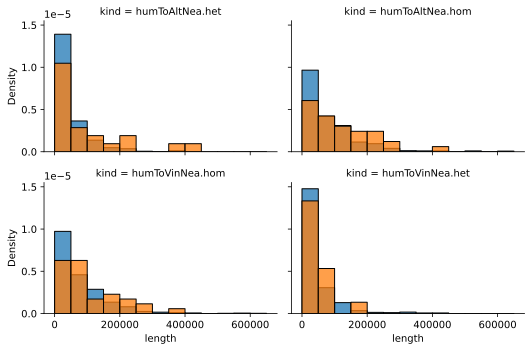

In [8]:
#| label: fig-hum-nean-length-distribution

g = sns.FacetGrid(data=plot_df.loc[plot_df.label.str.startswith('hum')], col='kind', 
                  col_wrap=2, hue='chrom_group', aspect=1.5, height=2.5)
g.map(sns.histplot, 'length', stat='density', bins=range(0, 700000, 50000)) ;

In [9]:
altai_annot = [(x.chrom, x.start, x.end) for x in altai_hom_coord.itertuples()] + \
    [(x.chrom, x.start, x.end) for x in altai_het_coord.itertuples()]
vindia_annot = [(x.chrom, x.start, x.end) for x in vindia_hom_coord.itertuples()] + \
    [(x.chrom, x.start, x.end) for x in vindia_het_coord.itertuples()]

#gi.chrom_ideogram(altai_annot + vindia_annot, figsize=(12,8))

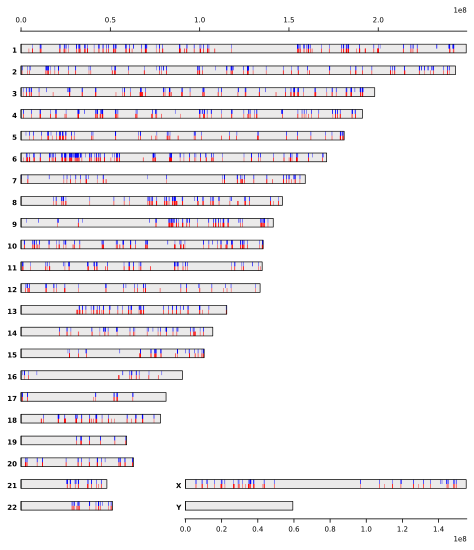

In [10]:
#| label: fig-hum-nean-genome-ideogram-tall
#| fig-cap: "Modern human introgression into Neanderthals ~250,000 BP"

g = gplt.GenomeIdeogram(assembly='hg19', axes_height_inches=0.4, axes_width_inches=8)
g.draw_chromosomes(height=4)
g.add_segments(altai_annot, facecolor='red', base=4, height=2, label='Altai')
g.add_segments(vindia_annot, facecolor='blue', base=6, height=2, label='Vindia')
#gid.add_legend()

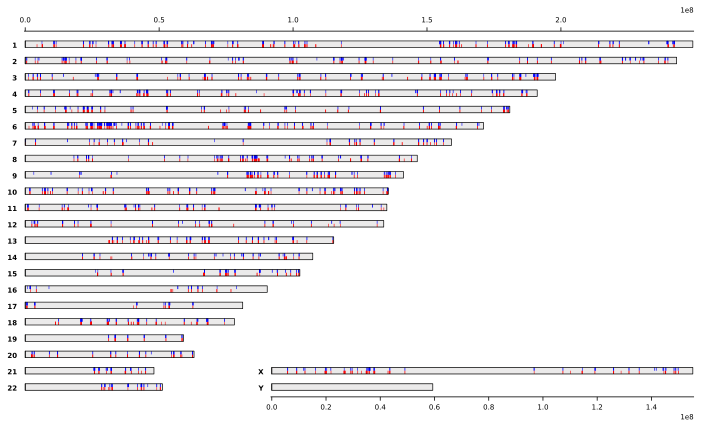

In [11]:
#| label: fig-hum-nean-genome-ideogram

g = gplt.GenomeIdeogram(assembly='hg19', axes_height_inches=0.3) 
g.draw_chromosomes(height=4)
g.add_segments(altai_annot, facecolor='red', base=4, height=2, label='Altai')
g.add_segments(vindia_annot, facecolor='blue', base=6, height=2, label='Vindia')
#gid.add_legend()

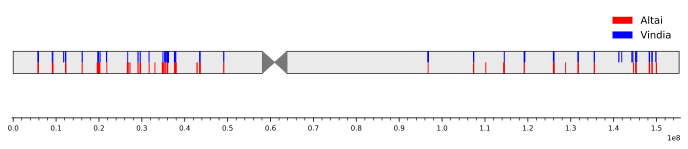

In [12]:
g = gplt.ChromIdeogram('chrX', assembly='hg19') 
g.draw_chromosomes()
g.add_segments([x for x in altai_annot if x[0] == 'chrX'], facecolor='red', base=4, height=1, label='Altai')
g.add_segments([x for x in vindia_annot if x[0] == 'chrX'], facecolor='blue', base=5, height=1, label='Vindia')
g.add_legend()

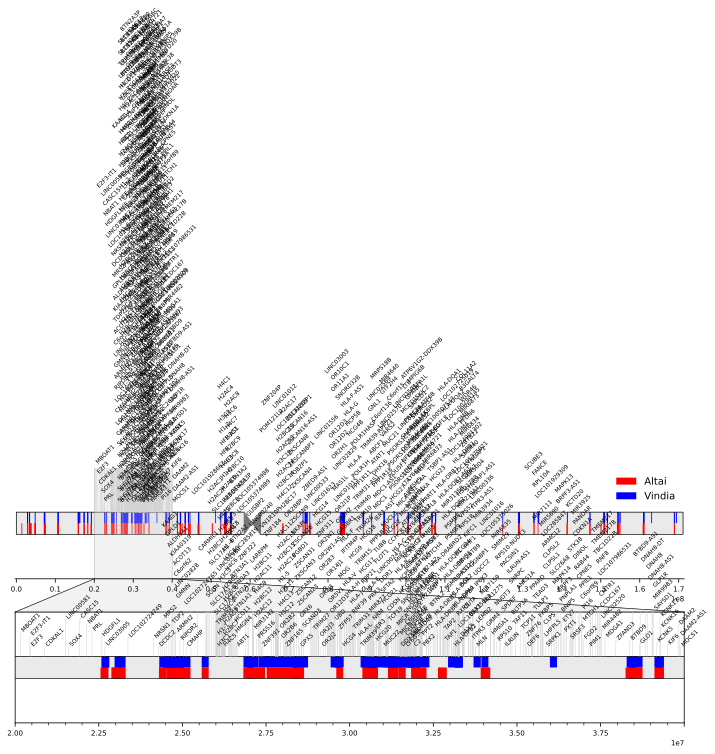

In [13]:
g = gplt.ChromIdeogram('chr6', assembly='hg19',
                      zooms=[(20_000_000, 40_000_000)]) 
g.draw_chromosomes()
g.add_segments([x for x in altai_annot if x[0] == 'chr6'], facecolor='red', base=4, height=1, label='Altai')
g.add_segments([x for x in vindia_annot if x[0] == 'chr6'], facecolor='blue', base=5, height=1, label='Vindia')
g.add_labels(gi.gene_labels_region('chr6', 20_000_000, 40_000_000, assembly='hg19'))
g.add_legend()

In [14]:
lst = []
for chrom, start, end in altai_annot:
    if chrom != 'chrX':
        continue
    lst.extend([x[0] for x in gi.gene_coords_region(chrom, start, end, assembly='hg19')])
hum_altai_genes = glist(sorted(set(lst)))
hum_altai_genes

ADGRG4       DIAPH2       FRMPD4       MAGEA8       MIR890       PRR32        SRPX         
ATG4A        DIAPH2-AS1   HS6ST2       MAGEA8-AS1   MIR891A      PSMD10       SYTL5        
BCLAF3       DMD          HS6ST2-AS1   MAOA         MIR891B      RBMXL3       VSIG1        
CACNA1F      DYNLT3       IL1RAPL1     MAP7D2       MIR892A      RHOXF1-AS1   XK           
CCDC22       EIF1AX       LANCL3       MBTPS2       MIR892B      RHOXF1P1     YY2          
CD99L2       EIF1AX-AS1   LINC00850    MIR23C       MIR892C      RPS6KA3                   
CFAP47       FAM47B       LOC105373150 MIR4666B     NLGN4X       SCARNA9L                  
COL4A6       FLICR        LOC729609    MIR548AJ2    PAK3         SH3KBP1                   
CYBB         FOXP3        LRCH2        MIR888       PPP1R3F      SMPX

In [15]:
lst = []
for chrom, start, end in vindia_annot:
    if chrom != 'chrX':
        continue
    lst.extend([x[0] for x in gi.gene_coords_region(chrom, start, end, assembly='hg19')])
hum_vindia_genes = glist(sorted(set(lst)))
hum_vindia_genes

ADGRG4     CFAP47     DYNLT3     HS6ST2-AS1 MAGEA8-AS1 MIR891A    MTM1       RHOXF1     SMPX       
ATG4A      COL4A6     FAM9B      IL1RAPL1   MAOA       MIR891B    MTMR1      RHOXF1-AS1 SYTL5      
BCLAF3     CYBB       FLICR      LANCL3     MIR4666B   MIR892A    NLGN4X     RHOXF1P1   VSIG1      
CACNA1F    DIAPH2     FOXP3      LINC00850  MIR548AJ2  MIR892B    PPP1R3F    RHOXF2B    XK         
CCDC22     DIAPH2-AS1 FRMPD4     LINC01402  MIR888     MIR892C    PRR32      RPS6KA3               
CD99L2     DMD        HS6ST2     MAGEA8     MIR890     MSL3       PSMD10     SH3KBP1

In [16]:
hum_nean_genes = hum_altai_genes | hum_vindia_genes
hum_nean_genes

ADGRG4       DIAPH2-AS1   HS6ST2       MAGEA8-AS1   MIR891B      PRR32        SMPX         
ATG4A        DMD          HS6ST2-AS1   MAOA         MIR892A      PSMD10       SRPX         
BCLAF3       DYNLT3       IL1RAPL1     MAP7D2       MIR892B      RBMXL3       SYTL5        
CACNA1F      EIF1AX       LANCL3       MBTPS2       MIR892C      RHOXF1       VSIG1        
CCDC22       EIF1AX-AS1   LINC00850    MIR23C       MSL3         RHOXF1-AS1   XK           
CD99L2       FAM47B       LINC01402    MIR4666B     MTM1         RHOXF1P1     YY2          
CFAP47       FAM9B        LOC105373150 MIR548AJ2    MTMR1        RHOXF2B                   
COL4A6       FLICR        LOC729609    MIR888       NLGN4X       RPS6KA3                   
CYBB         FOXP3        LRCH2        MIR890       PAK3         SCARNA9L                  
DIAPH2       FRMPD4       MAGEA8       MIR891A      PPP1R3F      SH3KBP1

**NB:** removing microRNA genes from set overlapping human to neanderthal admixture (for a fair comparison since Meritxell is not able to find miRNAs):

In [17]:
human_nean_genes = glist([g for g in hum_nean_genes if not g.startswith('MIR')])
human_nean_genes << hum_altai_genes

ADGRG4       DIAPH2       FOXP3        LOC729609    MTMR1        RHOXF1P1     XK           
ATG4A        DIAPH2-AS1   FRMPD4       LRCH2        NLGN4X       RHOXF2B      YY2          
BCLAF3       DMD          HS6ST2       MAGEA8       PAK3         RPS6KA3                   
CACNA1F      DYNLT3       HS6ST2-AS1   MAGEA8-AS1   PPP1R3F      SCARNA9L                  
CCDC22       EIF1AX       IL1RAPL1     MAOA         PRR32        SH3KBP1                   
CD99L2       EIF1AX-AS1   LANCL3       MAP7D2       PSMD10       SMPX                      
CFAP47       FAM47B       LINC00850    MBTPS2       RBMXL3       SRPX                      
COL4A6       FAM9B        LINC01402    MSL3         RHOXF1       SYTL5                     
CYBB         FLICR        LOC105373150 MTM1         RHOXF1-AS1   VSIG1

## Overlap hum-nean with cDEG genes

mc_ampl_SPANXN5 not found


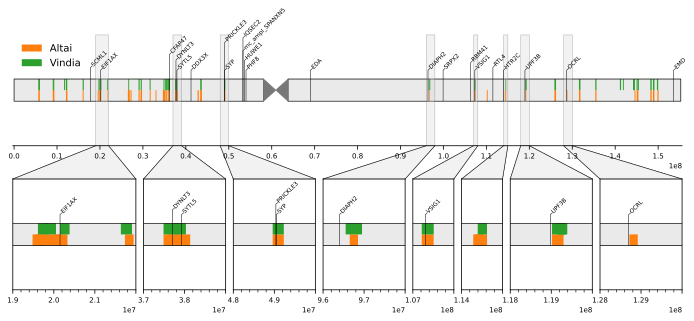

In [18]:
#| label: fig-hum-nean-cDEG-overlap

g = gplt.ChromIdeogram('chrX', assembly='hg19', #rel_font_height=0.04,
    zooms=[
        (19_000_000, 22_000_000),
        (37_000_000, 39_000_000),
        (48_000_000, 50_000_000),
        (96_000_000, 98_000_000),
        (107_000_000, 108_000_000),
        (114_000_000, 115_000_000),
        (118_000_000, 120_000_000),
        (128_000_000, 130_000_000),
    ]
)
g.draw_chromosomes()
g.add_segments(list(filter(lambda x: x[0] == 'chrX', altai_annot)), facecolor='tab:orange', base=4, height=1, label='Altai', alpha=0.7)
g.add_segments(list(filter(lambda x: x[0] == 'chrX', vindia_annot)), facecolor='tab:green', base=5, height=1, label='Vindia', alpha=0.7)

# def color(name):
#     return 'black' if name in hum_nean_genes else 'black'

coords = gi.gene_labels(sheet.get('cDEG'), assembly='hg19')
g.add_labels(coords, base=g.ideogram_base, min_height=g.ideogram_height*1.5, zorder=10, color='black')
# coords.extend(
#     [(tup[0], (tup[1]+tup[2])/2, name) for name, tup in gi.gene_coord(cDEG_genes, species='homo_sapiens', assembly='hg19').items()]
# )
# g.add_labels(coords, base=g.ideogram_base, min_height=g.ideogram_height*1.5, zorder=10, color='red')
g.add_legend()

In [19]:
#| label: doc-hum-nean-cDEG-overlap-fisher

human_nean_genes << sheet.get('cDEG')

ADGRG4       DIAPH2       FOXP3        LOC729609    MTMR1        RHOXF1P1     XK           
ATG4A        DIAPH2-AS1   FRMPD4       LRCH2        NLGN4X       RHOXF2B      YY2          
BCLAF3       DMD          HS6ST2       MAGEA8       PAK3         RPS6KA3                   
CACNA1F      DYNLT3       HS6ST2-AS1   MAGEA8-AS1   PPP1R3F      SCARNA9L                  
CCDC22       EIF1AX       IL1RAPL1     MAOA         PRR32        SH3KBP1                   
CD99L2       EIF1AX-AS1   LANCL3       MAP7D2       PSMD10       SMPX                      
CFAP47       FAM47B       LINC00850    MBTPS2       RBMXL3       SRPX                      
COL4A6       FAM9B        LINC01402    MSL3         RHOXF1       SYTL5                     
CYBB         FLICR        LOC105373150 MTM1         RHOXF1-AS1   VSIG1

$$
\begin{bmatrix}
    x &  n - x \\
N - x & \,  M - (n + N) + x
\end{bmatrix}
$$

$$
\frac{ \binom{N}{x} \binom{M-N}{n-x} }{ \binom{M}{n} }
$$

In [20]:
p, table = human_nean_genes.fisher(sheet.get('cDEG'), sheet.get('all_npx'), return_counts=True)
print(f'{p:e}')
df = pd.DataFrame(table, columns=(True, False), index=(True, False))
df.columns.name = 'human_nean_genes'
df.index.name = 'cDEG'
df

1.017050e-04


human_nean_genes  True   False
cDEG                          
True                  6     15
False                50   1341

In [21]:
p, table = (human_nean_genes & sheet.get('meritxell_spermatid_expr')).fisher(sheet.get('cDEG'), sheet.get('meritxell_spermatid_expr'), return_counts=True)
print(f'{p:e}')
df = pd.DataFrame(table, columns=(True, False), index=(True, False))
df.columns.name = 'human_nean_genes'
df.index.name = 'cDEG'
df

2.407482e-04


human_nean_genes  True   False
cDEG                          
True                  6     15
False                30    708

## Overlap hum-nean with nDEG genes

CSNKA2IP not found
mc_ampl_BEX2 not found
mc_ampl_CDY1 not found
mc_ampl_CLCN4 not found
mc_ampl_CT83 not found
mc_ampl_CXorf49B not found
mc_ampl_CXorf51A not found
mc_ampl_ETDB not found
mc_ampl_FAM47B not found
mc_ampl_FRMPD3 not found
mc_ampl_GK not found
mc_ampl_H2AL3 not found
mc_ampl_HMGB3 not found
mc_ampl_HSFX3 not found
mc_ampl_HSFY2 not found
mc_ampl_MAOA not found
mc_ampl_MTMR1 not found
mc_ampl_NXF3 not found
mc_ampl_PABIR2 not found
mc_ampl_PABPC1L2A not found
mc_ampl_PHKA2 not found
mc_ampl_PRDX4 not found
mc_ampl_SPACA5 not found
mc_ampl_SPANXN5 not found
mc_ampl_TEX13B not found
mc_ampl_TMSB15B not found
mc_ampl_TSC22D3 not found
mc_ampl_TSPAN7 not found
mc_ampl_VCX2 not found


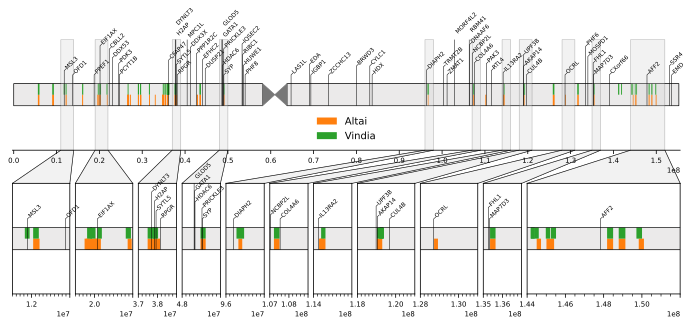

In [22]:
g = gplt.ChromIdeogram('chrX', assembly='hg19', #rel_font_height=0.04,
    zooms=[
        (11_000_000, 14_000_000),
        (19_000_000, 22_000_000),
        (37_000_000, 39_000_000),
        (48_000_000, 50_000_000),
        (96_000_000, 98_000_000),
        (107_000_000, 109_000_000),
        (114_000_000, 116_000_000),
        (118_000_000, 121_000_000),
        (128_000_000, 131_000_000),
        (135_000_000, 137_000_000),
        (144_000_000, 152_000_000),
    ]
)
g.draw_chromosomes()
g.add_segments(list(filter(lambda x: x[0] == 'chrX', altai_annot)), facecolor='tab:orange', base=4, height=1, label='Altai', alpha=0.7)
g.add_segments(list(filter(lambda x: x[0] == 'chrX', vindia_annot)), facecolor='tab:green', base=5, height=1, label='Vindia', alpha=0.7)

coords = gi.gene_labels(sheet.get('nDEG'), assembly='hg19')
g.add_labels(coords, base=g.ideogram_base, min_height=g.ideogram_height*1.5, zorder=10, color='black')
g.add_legend()

In [23]:
human_nean_genes.fisher(sheet.get('nDEG'), sheet.get('all_npx'))

0.0013367704082282226

## cDEG eith human-neanm Xie, Gametologs, Xi_copy_modul

In [24]:
sheet.get('xi_escape') << sheet.get('nDEG')

AFF2    CDK16   EFNB1   GPR173  IKBKG   MAMLD1  OFD1    PPP2R3B SEPTIN6 TCEAL9  XG      
AKAP17A CDR1    EIF1AX  GPR174  IL3RA   MAP7D2  P2RY10  PQBP1   SLC25A6 TCEANC  XIST    
ALG13   CHM     EIF2S3  GTPBP6  IQSEC2  MED14   P2RY8   PRKX    SMC1A   TRAPPC2 XPNPEP2 
AP1S2   COX7B   FGF13   GYG2    JPX     MSL3    PDZD11  PUDP    SRPX    TXLNG   ZBED1   
ARSD    CXorf38 FHL1    HCFC1   KDM5C   MXRA5   PHKA1   RAB9A   STK26   UBA1    ZFX     
ASMTL   CXorf65 FOXO4   HEPH    KDM6A   NAA10   PLCXD1  RBBP7   STS     UBQLN2  ZRSR2   
CA5B    DDX3X   FUNDC1  HMGN5   LRCH2   NHS     PNPLA4  RPS4X   SYAP1   USP9X           
CD99    DHRSX   GEMIN8  HUWE1   MAGEE1  NHSL2   PORCN   SCML2   TASL    WAS

In [25]:
sheet.get('xi_escape').fisher(sheet.get('nDEG'), sheet.get('all_npx'))

0.008679557630393627

In [26]:
sheet.get('gametologs') << sheet.get('nDEG')

AKAP17AX CCNQX    EIF2S3X  KDM6A    NLGN4X   PRPS2X   RPS4X    TAB3X    TMSB4X   USP9X    ZBED1X   
AMELX    DDX3X    HSFX     MBTPS2X  P2RY8X   RBMX     SOX3     TBL1X    TSPX     UTY      ZFX      
ASMTX    DHRSX    KDM5C    MSL3X    PCDH11X  RPL10X   SPANXNX  TGIF2LX  TXLNGX   VCX               
BCORX    EIF1AX   KDM5D    MXRA5X   PRKX     RPL36AX  SRY      THOC2X   UBA1X    XKRX

In [27]:
sheet.get('gametologs').fisher(sheet.get('nDEG'), sheet.get('all_npx'))

0.16232090954973297

In [28]:
sheet.get('expr_mod_xi_copynr')

ACOT9    DDX3X    GDI1     MBTPS2   PLCXD1   SASH3    SYAP1    UBA1     ZNF41    
AMMECR1  DNASE1L1 GPR174   MED14    PRKX     SMC1A    TBC1D8B  VAMP7             
CA5B     EIF1AX   GRIPAP1  MPP1     PUDP     STK26    TBL1X    XG                
CXorf38  FMR1     MAP7D3   P2RY10   RBBP7    STS      TMSB4X   ZFX

In [29]:
sheet.get('xi_escape') & sheet.get('gametologs') & sheet.get('expr_mod_xi_copynr')

DDX3X  EIF1AX PRKX   ZFX

In [30]:
(sheet.get('xi_escape') & sheet.get('gametologs') & sheet.get('expr_mod_xi_copynr')).fisher(sheet.get('nDEG'), sheet.get('all_npx'))

0.009120081655134856

In [31]:
(sheet.get('xi_escape') & sheet.get('gametologs')).fisher(sheet.get('nDEG'), sheet.get('all_npx'))

0.03834380261145926

In [32]:
sheet.get('expr_mod_xi_copynr')

ACOT9    DDX3X    GDI1     MBTPS2   PLCXD1   SASH3    SYAP1    UBA1     ZNF41    
AMMECR1  DNASE1L1 GPR174   MED14    PRKX     SMC1A    TBC1D8B  VAMP7             
CA5B     EIF1AX   GRIPAP1  MPP1     PUDP     STK26    TBL1X    XG                
CXorf38  FMR1     MAP7D3   P2RY10   RBBP7    STS      TMSB4X   ZFX

In [33]:
sheet.get('expr_mod_xi_copynr').fisher(sheet.get('cDEG'), sheet.get('all_npx'))

0.0799648944809562

In [34]:
sheet.get('accel_reg_simiiformes_br')

ACSL4      AR         DIAPH2     FANCB      GRIA3      MTMR8      PIR        SH3KBP1    
AF241726.2 ATXN3L     DMD        FGF13      GRIA3      NAP1L3     PLAC1      SLC9A6     
AFF2       CASK       DRP2       FRMPD3     LHFPL1     NEXMIF     POLA1      SPANXN2    
AKAP14     CD99L2     EDA        FRMPD4     MAOB       NOX1       PORCN      TMEM47     
AL133500.1 CLCN5      FAM122B    GNL3L      MBNL3      OTUD6A     RAI2       ZNF75D     
ALG13      COL4A6     FAM133A    GPC3       MED14      PABPC5     RBM10                 
AMMECR1    CPXCR1     FAM47B     GPR174     MOSPD2     PCDH19     SH2D1A

In [35]:
sheet.get('accel_reg_simiiformes_br').fisher(sheet.get('cDEG'), sheet.get('all_npx'))

0.16861058934101547

In [36]:
sheet.get('ari_nonPUR')

AMMECR1      DMD          HUWE1        LOC112268307 NYX          PTCHD1-AS    TMLHE        
ARSL         ENOX2        IGSF1        LOC124905191 PAK3         RAB33A       WWC3         
BCOR         FAM120C      IL1RAPL1     MAGT1        PASD1        RAP2C-AS1    XPNPEP2      
CASK         FRMPD4       LINC01278    MAMLD1       PHKA1        RTL4         ZMYM3        
CDKL5        G6PD         LOC101928359 MIR325HG     PRKX         TENM1                     
CLCN4        GNL3L        LOC105377212 NHS          PTCHD1       TMEM164

In [37]:
sheet.get('ari_nonPUR').fisher(sheet.get('cDEG'), sheet.get('all_npx'))

0.11718488335444423

In [38]:
((sheet.get('ech90_regions') | hum_nean_genes) & sheet.get('xi_escape')).fisher(sheet.get('cDEG'), sheet.get('all_npx'))

0.13957221166160091

In [39]:
hum_nean_genes.fisher(sheet.get('cDEG'), sheet.get('all_npx'))

0.0002590758433087752

In [40]:
hum_nean_genes.fisher(sheet.get('sfari_all_conf'), sheet.get('all_npx'))

0.002254877128105195

In [ ]:
def fisher_test(a, b, bg):
    _a, _b, _bg = sheet.get(a), sheet.get(b), sheet.get(bg)
    p = (_a & _bg).fisher((_b & _bg), _bg)
    return a, b, bg, p

 

In [120]:
def fisher_test(a, b, bg):
    _a, _b, _bg = sheet.get(a), sheet.get(b), sheet.get(bg)
    p = (_a & _bg).fisher((_b & _bg), _bg)
    return a, b, bg, p
    # print(f'{bg.ljust(25)} {a.ljust(25)} {b.ljust(25)} {p:.2e}')

print(f'{'background'.ljust(25)} {'set1'.ljust(25)} {'set2'.ljust(25)} p-value')

fisher_test('hpa_brain_prot', 'hum_nean_admix', 'all_npx')
fisher_test('cDEG', 'hum_nean_admix', 'hpa_brain_prot')
fisher_test('meritxell_spermatid_expr', 'hum_nean_admix', 'hpa_brain_prot')
fisher_test('meritxell_spermatid_expr', 'hum_nean_admix', 'all_npx')
fisher_test('sfari_all_conf', 'hum_nean_admix', 'all_npx')
fisher_test('sfari_all_conf', 'hum_nean_admix', 'meritxell_spermatid_expr')
fisher_test('cDEG', 'hum_nean_admix', 'meritxell_spermatid_expr')

fisher_test('cDEG', 'ech90_regions', 'meritxell_spermatid_expr')
fisher_test('hum_nean_admix', 'ech90_regions', 'all_npx')

fisher_test('ari_all', 'ech90_regions', 'all_npx')
fisher_test('ari_nonPUR', 'ech90_regions', 'all_npx')
fisher_test('ari_all', 'ech90_regions', 'nDEG')
fisher_test('pure_hama', 'ech90_regions', 'all_npx')

fisher_test('sfari_all_conf', 'accel_reg_simiiformes_br', 'all_npx')
fisher_test('sfari_all_conf', 'accel_reg_simiiformes_br', 'meritxell_spermatid_expr')
fisher_test('sfari_all_conf', 'accel_reg_simiiformes_br', 'hpa_brain_prot')
fisher_test('sfari_all_conf', 'meritxell_spermatid_expr', 'hpa_brain_prot')




#accel_reg_simiiformes_br


background                set1                      set2                      p-value
all_npx                   hpa_brain_prot            hum_nean_admix            1.04e-01
hpa_brain_prot            cDEG                      hum_nean_admix            1.35e-02
hpa_brain_prot            meritxell_spermatid_expr  hum_nean_admix            2.92e-02
all_npx                   meritxell_spermatid_expr  hum_nean_admix            7.10e-03
all_npx                   sfari_all_conf            hum_nean_admix            2.25e-03
meritxell_spermatid_expr  sfari_all_conf            hum_nean_admix            2.88e-03
meritxell_spermatid_expr  cDEG                      hum_nean_admix            2.41e-04
meritxell_spermatid_expr  cDEG                      ech90_regions             4.91e-02
all_npx                   hum_nean_admix            ech90_regions             9.14e-04
all_npx                   ari_all                   ech90_regions             5.70e-04
all_npx                   ari_nonPUR        

In [ ]:
hum_nean_genes.fisher(sheet.get('sfari_all_conf'), sheet.get('all_npx'))
ari_nonPUR